In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sympy
import torch

In [2]:
wavelength = 1550
k = 2 * np.pi / wavelength
Lx = 2040
Ly = 2040
Nx = 166
Ny = 166

x = np.linspace(-Lx/2, Lx/2, Nx)
y = np.linspace(-Ly/2, Ly/2, Ny)

X,Y = np.meshgrid(x,y)

z = np.linspace(1, 775, 100)

In [8]:
def euclidean_distance(s, d) -> float:
    # s -> source point
    # d -> destination (receiving point)
    s = np.asarray(s)
    d = np.asarray(d)
    return np.linalg.norm(s - d)


def free_space_transfer_function_3d(r_s, r_r, k) -> np.ndarray:
    """
    Computes the 3D free-space Green's function between source and receiver points.

    Args:
        r_s (np.ndarray): Array of source points, shape (Ns, 3)
        r_r (np.ndarray): Array of receiver points, shape (Nr, 3)
        k (float): Wavenumber

    Returns:
        g (np.ndarray): Transfer function matrix of shape (Nr, Ns)
        check_d (float): Distance for a specific check case (optional debug)
    """
    r_s = np.asarray(r_s)
    r_r = np.asarray(r_r)
    g = np.zeros((len(r_r), len(r_s)), dtype=complex)

    check_d = None
    for i, r in enumerate(r_r):
        for j, s in enumerate(r_s):
            d = euclidean_distance(s, r)
            if j == 2 and i == 0:
                check_d = d
            numerator = -np.exp(1j * k * d)
            denominator = 4 * np.pi * d
            #g[i, j] = np.round(numerator / denominator, 5)  # rounding may be unnecessary for production
            g[i, j] = numerator / denominator
    return g, check_d

def free_space_transfer_function_3d_vectorized(r_s, r_r, k):
    """
    Vectorized computation of the 3D free-space Green's function.

    Args:
        r_s (np.ndarray): Source points of shape (Ns, 3)
        r_r (np.ndarray): Receiver points of shape (Nr, 3)
        k (float): Wavenumber

    Returns:
        g (np.ndarray): Transfer function matrix of shape (Nr, Ns)
    """
    # Ensure input shapes
    r_s = np.asarray(r_s)  # (Ns, 3)
    r_r = np.asarray(r_r)  # (Nr, 3)

    # Compute pairwise distances: ||r_r[i] - r_s[j]|| for all i, j
    # r_r[:, np.newaxis, :] shape: (Nr, 1, 3)
    # r_s[np.newaxis, :, :] shape: (1, Ns, 3)
    diffs = r_r[:, np.newaxis, :] - r_s[np.newaxis, :, :]  # shape: (Nr, Ns, 3)
    dists = np.linalg.norm(diffs, axis=-1)  # shape: (Nr, Ns)

    # Avoid division by zero (diagonal terms)
    dists = np.where(dists == 0, 1e-10, dists)

    # Compute Green's function: G = -exp(ikr) / (4πr)
    g = -np.exp(1j * k * dists)
    
    g *= -1.0 / (4 * np.pi * dists)

    return g

def compute_greens_blockwise(r_s, r_r, k, block_size=8000):
    Ns, Nr = len(r_s), len(r_r)
    g = np.zeros((Nr, Ns), dtype=np.complex64)
    for i in range(0, Nr, block_size):
        r_r_block = r_r[i:i+block_size]
        diffs = r_r_block[:, None, :] - r_s[None, :, :]
        dists = np.linalg.norm(diffs, axis=-1)
        dists = np.where(dists == 0, 1e-10, dists)
        g_block = -np.exp(1j * k * dists) / (4 * np.pi * dists)
        g[i:i+block_size] = g_block.astype(np.complex64)
    return g


def sum_rule(g: np.ndarray) -> float:
    return np.linalg.norm(g, 'fro')**2


def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

In [4]:
# Flatten and stack into shape (N, 3)
r_s = np.stack([X.ravel(), Y.ravel(), np.full(X.size, 0)], axis=1)
r_r = np.stack([X.ravel(), Y.ravel(), np.full(X.size, z[-1])], axis=1)

In [5]:
#Gsr, check_d = free_space_transfer_function_3d(r_s, r_r, k)
Gsr = compute_greens_blockwise(r_s, r_r, k)

In [11]:
Gsr.shape

(27556, 27556)

In [12]:
Gsr

array([[ 1.02680606e-04-1.2574748e-20j,  1.02667538e-04+4.1040671e-08j,
         1.02628255e-04+1.6406869e-07j, ...,
        -2.31795311e-05+1.3431285e-05j, -2.35568168e-05+1.2598558e-05j,
        -2.39058281e-05+1.1753167e-05j],
       [ 1.02667538e-04+4.1040671e-08j,  1.02680606e-04-1.2574748e-20j,
         1.02667538e-04+4.1040671e-08j, ...,
        -2.27745350e-05+1.4250416e-05j, -2.31795311e-05+1.3431285e-05j,
        -2.35568168e-05+1.2598558e-05j],
       [ 1.02628255e-04+1.6406869e-07j,  1.02667538e-04+4.1040671e-08j,
         1.02680606e-04-1.2574748e-20j, ...,
        -2.23424249e-05+1.5055046e-05j, -2.27745350e-05+1.4250416e-05j,
        -2.31795311e-05+1.3431285e-05j],
       ...,
       [-2.31795311e-05+1.3431285e-05j, -2.27745350e-05+1.4250416e-05j,
        -2.23424249e-05+1.5055046e-05j, ...,
         1.02680606e-04-1.2574748e-20j,  1.02667538e-04+4.1040671e-08j,
         1.02628255e-04+1.6406869e-07j],
       [-2.35568168e-05+1.2598558e-05j, -2.31795311e-05+1.3431285e-0

In [13]:
S = sum_rule(Gsr)

In [14]:
S.shape

()

In [16]:
Gsrd_Gsr = np.matmul(np.matrix.getH(Gsr), Gsr)

In [17]:
from scipy.linalg import eigh
eig_vals_0, eig_vect_0 = eigh(Gsrd_Gsr)

In [18]:
eig_vals_0.shape

(27556,)

In [19]:
eig_vals_flipped = np.flip(eig_vals_0)

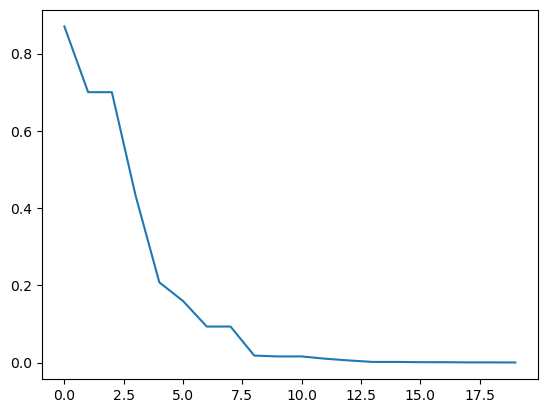

In [23]:
plt.plot(eig_vals_flipped[0:20])